# ECE Final Project: Bayes Classifier Notebook

In [1]:
#Imports_______________________________________________________________________________
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from sklearn.metrics import accuracy_score
from keras.datasets import cifar10
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

2024-05-04 16:01:26.185012: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-04 16:01:26.190796: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-04 16:01:27.558213: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
#Load in data, Normalize and format
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

#Normalize and format
train_images = train_images / 255 
test_images  = test_images / 255

In [26]:
#Compute PCA Features
X = train_images.reshape(-1, 3072) #flatten images: reshape data to Nx(32*32*3)
R = np.dot(X.T, X)                 #Compute autocorrelation matrix of data

evals, evecs = np.linalg.eig(R)    #eigendecomposition of R

In [27]:
#Compute number of eigen-images needed to capture 99% of data covariance
cutoff = 0.99
cov_sum = np.cumsum(evals)/np.sum(evals)
k = np.argmax(cov_sum>=cutoff)
print(k)

231


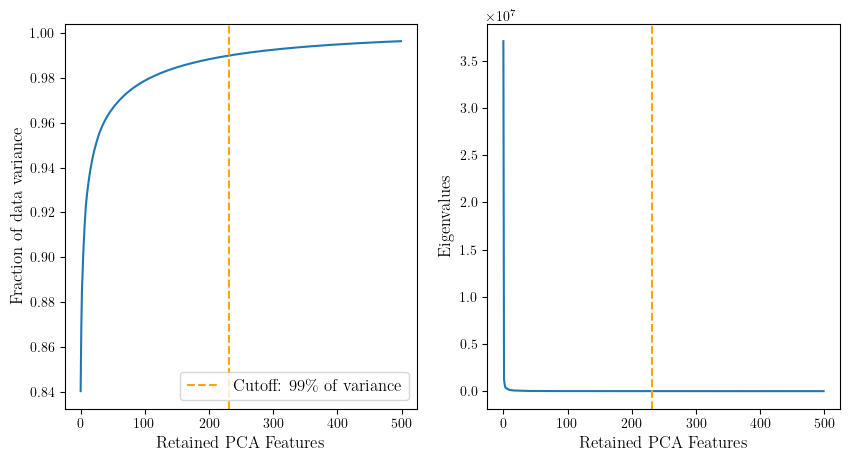

In [35]:
#Vizualize dominant eigenvalues
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[1].plot(np.arange(0, 500), evals[:500])
ax[1].set_ylabel('Eigenvalues', fontsize=12)
ax[1].set_xlabel('Retained PCA Features', fontsize=12)
ax[1].axvline(k, linestyle='--', color='orange', label='Cutoff: 99\% of variance')
#ax[1].yscale('log')
#ax[1].legend(fontsize=12)

ax[0].plot(np.arange(0, 500), cov_sum[:500])
ax[0].set_ylabel('Fraction of data variance', fontsize=12)
ax[0].set_xlabel('Retained PCA Features', fontsize=12)
ax[0].axvline(k, linestyle='--', color='orange', label='Cutoff: 99\% of variance')
ax[0].legend(fontsize=12)

In [28]:
#Apply dimensionality reduction
X_red = np.dot(X, evecs[:,:k])
Xt = test_images.reshape(-1, 3072)
Xt_red = np.dot(test_images.reshape(-1, 3072), evecs[:,:k])

In [8]:
#Test out naive bayes classifier with these PCA features
from sklearn.naive_bayes import GaussianNB
GNB = GaussianNB()
GNB.fit(X_red, train_labels)

test_pred = GNB.predict(Xt_red)
accuracy_score(test_labels, test_pred)

0.282

In [29]:
#Define Bayes Classifier
from scipy.stats import multivariate_normal as mvnorm

class Bayes_Classifier(object):
    def __init__(self):
        pass
    def fit(self, x, y):
        """
        Load in training data and compute 
        means, covariances, and priors for 
        each class. 
        __________________________________
        x: training data
        y: training labels

        returns: means, covariances, and priors.
        """
        means  = []
        covs   = []
        pri    = []
        
        label_list = np.unique(y)
        for i in range(len(label_list)):
            #Mask for current class
            mask = (y[:, 0] == label_list[i])
            xm = x[mask]

            #Append class mean, cov, prior prob
            means.append( np.mean(xm, axis=0) )
            covs.append( np.cov(xm.T) )
            pri.append( xm.shape[0]/x.shape[0] )

        

        self.means = np.array(means)
        self.covs  = np.array(covs)
        self.pri   = np.array (pri)
        return means, covs, pri


    def predict(self, x):
        """ 
        Predict labels of test data using posterior probabilities.
        __________________________________________________________
        x: training data

        returns: class of data. 
        """
        label_num = self.means.shape[0]

        # Calculate posterior probabilities
        probs = np.array([self.pri[i]*mvnorm.pdf(x, mean=self.means[i], cov=self.covs[i]) for i in range(label_num)])

        total = np.sum(probs, axis=0)

        norm_probs = probs / total

        #Assign class of maximum probability 
        mclass = np.argmax(norm_probs, axis=0)

        return np.array(mclass)
        
    def evaluate(self, x, y):
        """ 
        Evaluate accuracy of classification. 
        ____________________________________
        x: test data
        y: test labels
        """
        preds = self.predict(x)
        score = accuracy_score(y, preds)

        n_corr = np.sum(preds == y)
        n_tot  = x.shape[0]
        print('Accuracy: {:.3f}%'.format(100*score))
        return score, n_corr, n_tot

In [36]:
#With PCA
BC = Bayes_Classifier()
stats=BC.fit(X_red, train_labels)
preds = BC.predict(Xt_red)
BC.evaluate(Xt_red, test_labels)

Accuracy: 51.990%


(0.5199, 10000000, 10000)

In [31]:
#Without PCA
BC = Bayes_Classifier()
stats=BC.fit(X, train_labels)
preds = BC.predict(Xt)
BC.evaluate(Xt, test_labels)

Accuracy: 13.260%


(0.1326, 10000000, 10000)

Text(0.5, 1.0, 'PCA+BC Confusion')

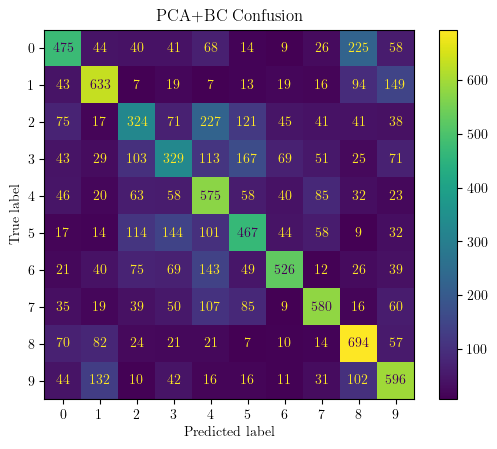

In [38]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

cm = confusion_matrix(test_labels, preds)

CM = ConfusionMatrixDisplay(cm)
CM.plot()
plt.title('PCA+BC Confusion')

In [90]:
#Test accuracy against number of PCA features
num_pca = np.floor(np.linspace(25, 1000, 50)).astype(int) 
accs=[]
for i in tqdm(num_pca):
    X_red = np.dot(X, evecs[:,:i])
    Xt = test_images.reshape(-1, 3072)
    Xt_red = np.dot(test_images.reshape(-1, 3072), evecs[:,:i])

    BC = Bayes_Classifier()
    stats=BC.fit(X_red, train_labels)
    print('PCA features:', i)
    eval=BC.evaluate(Xt_red, test_labels)
    accs.append(eval[0])

  0%|          | 0/50 [00:00<?, ?it/s]

PCA features: 25


  2%|▏         | 1/50 [00:00<00:36,  1.33it/s]

Accuracy: 27.27%
PCA features: 44


  4%|▍         | 2/50 [00:01<00:35,  1.37it/s]

Accuracy: 34.23%
PCA features: 64


  6%|▌         | 3/50 [00:02<00:35,  1.32it/s]

Accuracy: 40.03%
PCA features: 84


  8%|▊         | 4/50 [00:03<00:37,  1.24it/s]

Accuracy: 43.26%
PCA features: 104


 10%|█         | 5/50 [00:04<00:38,  1.18it/s]

Accuracy: 45.83%
PCA features: 124


 12%|█▏        | 6/50 [00:05<00:39,  1.11it/s]

Accuracy: 47.08%
PCA features: 144


 14%|█▍        | 7/50 [00:06<00:42,  1.02it/s]

Accuracy: 48.54%
PCA features: 164


 16%|█▌        | 8/50 [00:07<00:43,  1.04s/it]

Accuracy: 49.25%
PCA features: 184


 18%|█▊        | 9/50 [00:08<00:45,  1.11s/it]

Accuracy: 50.370000000000005%
PCA features: 204


 20%|██        | 10/50 [00:09<00:47,  1.18s/it]

Accuracy: 50.79%
PCA features: 223


 22%|██▏       | 11/50 [00:11<00:49,  1.28s/it]

Accuracy: 51.339999999999996%
PCA features: 243


 24%|██▍       | 12/50 [00:13<00:51,  1.37s/it]

Accuracy: 51.83%
PCA features: 263


 26%|██▌       | 13/50 [00:14<00:55,  1.51s/it]

Accuracy: 51.85999999999999%
PCA features: 283


 28%|██▊       | 14/50 [00:16<01:00,  1.68s/it]

Accuracy: 52.03%
PCA features: 303


 30%|███       | 15/50 [00:19<01:02,  1.79s/it]

Accuracy: 52.26%
PCA features: 323


 32%|███▏      | 16/50 [00:21<01:05,  1.93s/it]

Accuracy: 52.559999999999995%
PCA features: 343


 34%|███▍      | 17/50 [00:23<01:08,  2.08s/it]

Accuracy: 52.33%
PCA features: 363


 36%|███▌      | 18/50 [00:26<01:09,  2.17s/it]

Accuracy: 52.5%
PCA features: 383


 38%|███▊      | 19/50 [00:28<01:11,  2.30s/it]

Accuracy: 52.23%
PCA features: 403


 40%|████      | 20/50 [00:31<01:12,  2.41s/it]

Accuracy: 52.73%
PCA features: 422


 42%|████▏     | 21/50 [00:34<01:13,  2.55s/it]

Accuracy: 52.790000000000006%
PCA features: 442


 44%|████▍     | 22/50 [00:37<01:15,  2.70s/it]

Accuracy: 52.73%
PCA features: 462


 46%|████▌     | 23/50 [00:40<01:16,  2.82s/it]

Accuracy: 52.669999999999995%
PCA features: 482


 48%|████▊     | 24/50 [00:43<01:16,  2.93s/it]

Accuracy: 52.949999999999996%
PCA features: 502


 50%|█████     | 25/50 [00:46<01:15,  3.03s/it]

Accuracy: 52.72%
PCA features: 522


 52%|█████▏    | 26/50 [00:50<01:14,  3.09s/it]

Accuracy: 52.739999999999995%
PCA features: 542


 54%|█████▍    | 27/50 [00:53<01:13,  3.19s/it]

Accuracy: 52.62%
PCA features: 562


 56%|█████▌    | 28/50 [00:57<01:13,  3.35s/it]

Accuracy: 52.64%
PCA features: 582


 58%|█████▊    | 29/50 [01:01<01:14,  3.53s/it]

Accuracy: 52.690000000000005%
PCA features: 602


 60%|██████    | 30/50 [01:04<01:11,  3.59s/it]

Accuracy: 52.61%
PCA features: 621


 62%|██████▏   | 31/50 [01:08<01:10,  3.73s/it]

Accuracy: 52.66%
PCA features: 641


 64%|██████▍   | 32/50 [01:13<01:10,  3.89s/it]

Accuracy: 52.300000000000004%
PCA features: 661


 66%|██████▌   | 33/50 [01:17<01:08,  4.04s/it]

Accuracy: 52.55%
PCA features: 681


 68%|██████▊   | 34/50 [01:22<01:07,  4.23s/it]

Accuracy: 52.7%
PCA features: 701


 70%|███████   | 35/50 [01:27<01:06,  4.41s/it]

Accuracy: 52.78%
PCA features: 721


 72%|███████▏  | 36/50 [01:31<01:03,  4.52s/it]

Accuracy: 52.61%
PCA features: 741


 74%|███████▍  | 37/50 [01:36<01:00,  4.64s/it]

Accuracy: 52.54%
PCA features: 761


 76%|███████▌  | 38/50 [01:41<00:57,  4.79s/it]

Accuracy: 52.559999999999995%
PCA features: 781


 78%|███████▊  | 39/50 [01:47<00:54,  4.94s/it]

Accuracy: 52.04%
PCA features: 801


 80%|████████  | 40/50 [01:52<00:51,  5.19s/it]

Accuracy: 51.59%
PCA features: 820


 82%|████████▏ | 41/50 [01:58<00:48,  5.41s/it]

Accuracy: 51.11%
PCA features: 840


 84%|████████▍ | 42/50 [02:04<00:44,  5.57s/it]

Accuracy: 49.84%
PCA features: 860


 86%|████████▌ | 43/50 [02:11<00:40,  5.81s/it]

Accuracy: 48.559999999999995%
PCA features: 880


 88%|████████▊ | 44/50 [02:17<00:35,  5.94s/it]

Accuracy: 47.32%
PCA features: 900


 90%|█████████ | 45/50 [02:24<00:30,  6.16s/it]

Accuracy: 46.02%
PCA features: 920


 92%|█████████▏| 46/50 [02:30<00:25,  6.28s/it]

Accuracy: 44.629999999999995%
PCA features: 940


 94%|█████████▍| 47/50 [02:37<00:19,  6.48s/it]

Accuracy: 43.1%
PCA features: 960


 96%|█████████▌| 48/50 [02:44<00:13,  6.70s/it]

Accuracy: 41.65%
PCA features: 980


 98%|█████████▊| 49/50 [02:51<00:06,  6.82s/it]

Accuracy: 40.04%
PCA features: 1000


100%|██████████| 50/50 [02:59<00:00,  3.60s/it]

Accuracy: 38.58%


In [34]:
import matplotlib
matplotlib.rcParams.update({'text.usetex': True, 
                            'font.family': 'Computer Modern Roman'})

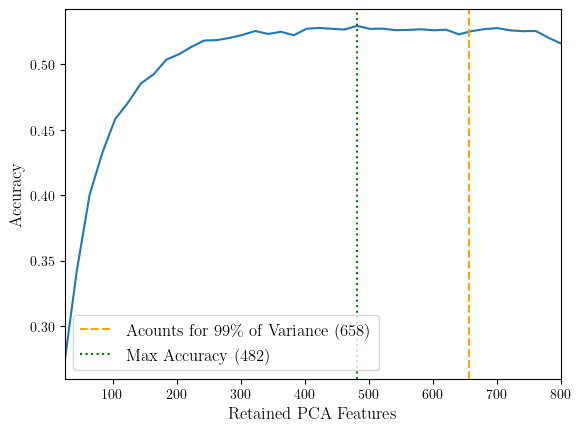

In [112]:
plt.plot(num_pca, accs)
plt.axvline(k, linestyle='--', color='orange', label='Acounts for 99\% of Variance ({})'.format(658))
plt.axvline(num_pca[np.argmax(accs)], linestyle=':', color='g', label='Max Accuracy ({})'.format(num_pca[np.argmax(accs)]))
plt.ylabel("Accuracy", fontsize=12)
plt.xlabel("Retained PCA Features", fontsize=12)
plt.margins(x=0)
plt.xlim((25, 800))
plt.legend(loc='lower left', fontsize=12)
plt.show()